# U-2-NET COMPLETE DEMONSTRATION
Demo by Shreyas Bhat Kera

**Setting up U2NET**

**Using U2NETp for :**
 - **Background Removal**
 - **Bounding Box Creation**
 - **Salient Feature Highlighting**


 U2NET Paper: [U2-Net: Going Deeper with Nested U-Structure for Salient Object Detection](https://arxiv.org/abs/2005.09007)

 Original Repo: [U-2-Net Github repo](https://github.com/NathanUA/U-2-Net)

References: X. Qin, Z. Zhang, C. Huang, M. Dehghan, O. R. Zaiane, and M. Jagersand, “U2-net: Going deeper with nested u-structure for salient object
detection,” Pattern Recognition, vol. 106, p. 107404, 2020

In [1]:
#check if GPU is available
!nvidia-smi

Wed Sep 15 17:32:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#Download and extract DUTS-TR Dataset
!mkdir -p data
!wget http://saliencydetection.net/duts/download/DUTS-TR.zip
!unzip DUTS-TR.zip -d data

Streaming output truncated to the last 5000 lines.
 extracting: data/DUTS-TR/DUTS-TR-Mask/n07718747_3382.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/n04270147_12691.png  
 extracting: data/DUTS-TR/DUTS-TR-Mask/n03211117_3402.png  
 extracting: data/DUTS-TR/DUTS-TR-Mask/ILSVRC2012_test_00000680.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/ILSVRC2012_val_00036949.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/ILSVRC2014_train_00033735.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/n01644900_4125.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/n04540053_2438.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/n03770439_7684.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/n07873807_5318.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/ILSVRC2014_train_00010870.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/n03764736_1884.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/n07742313_494.png  
 extracting: data/DUTS-TR/DUTS-TR-Mask/n03770439_218.png  
  inflating: data/DUTS-TR/DUTS-TR-Mask/ILSVRC2013_test_00009085.png  

Example Image from DUTS-TR

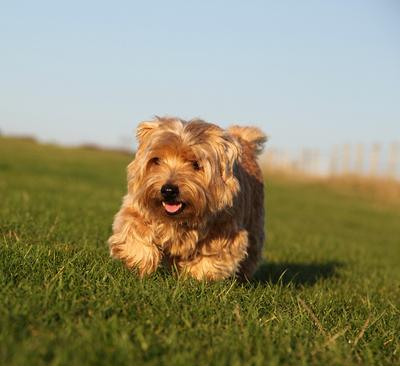

Example Mask from DUTS-TR

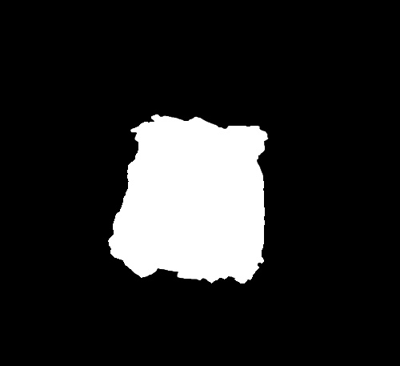

Model diagram for U2NET

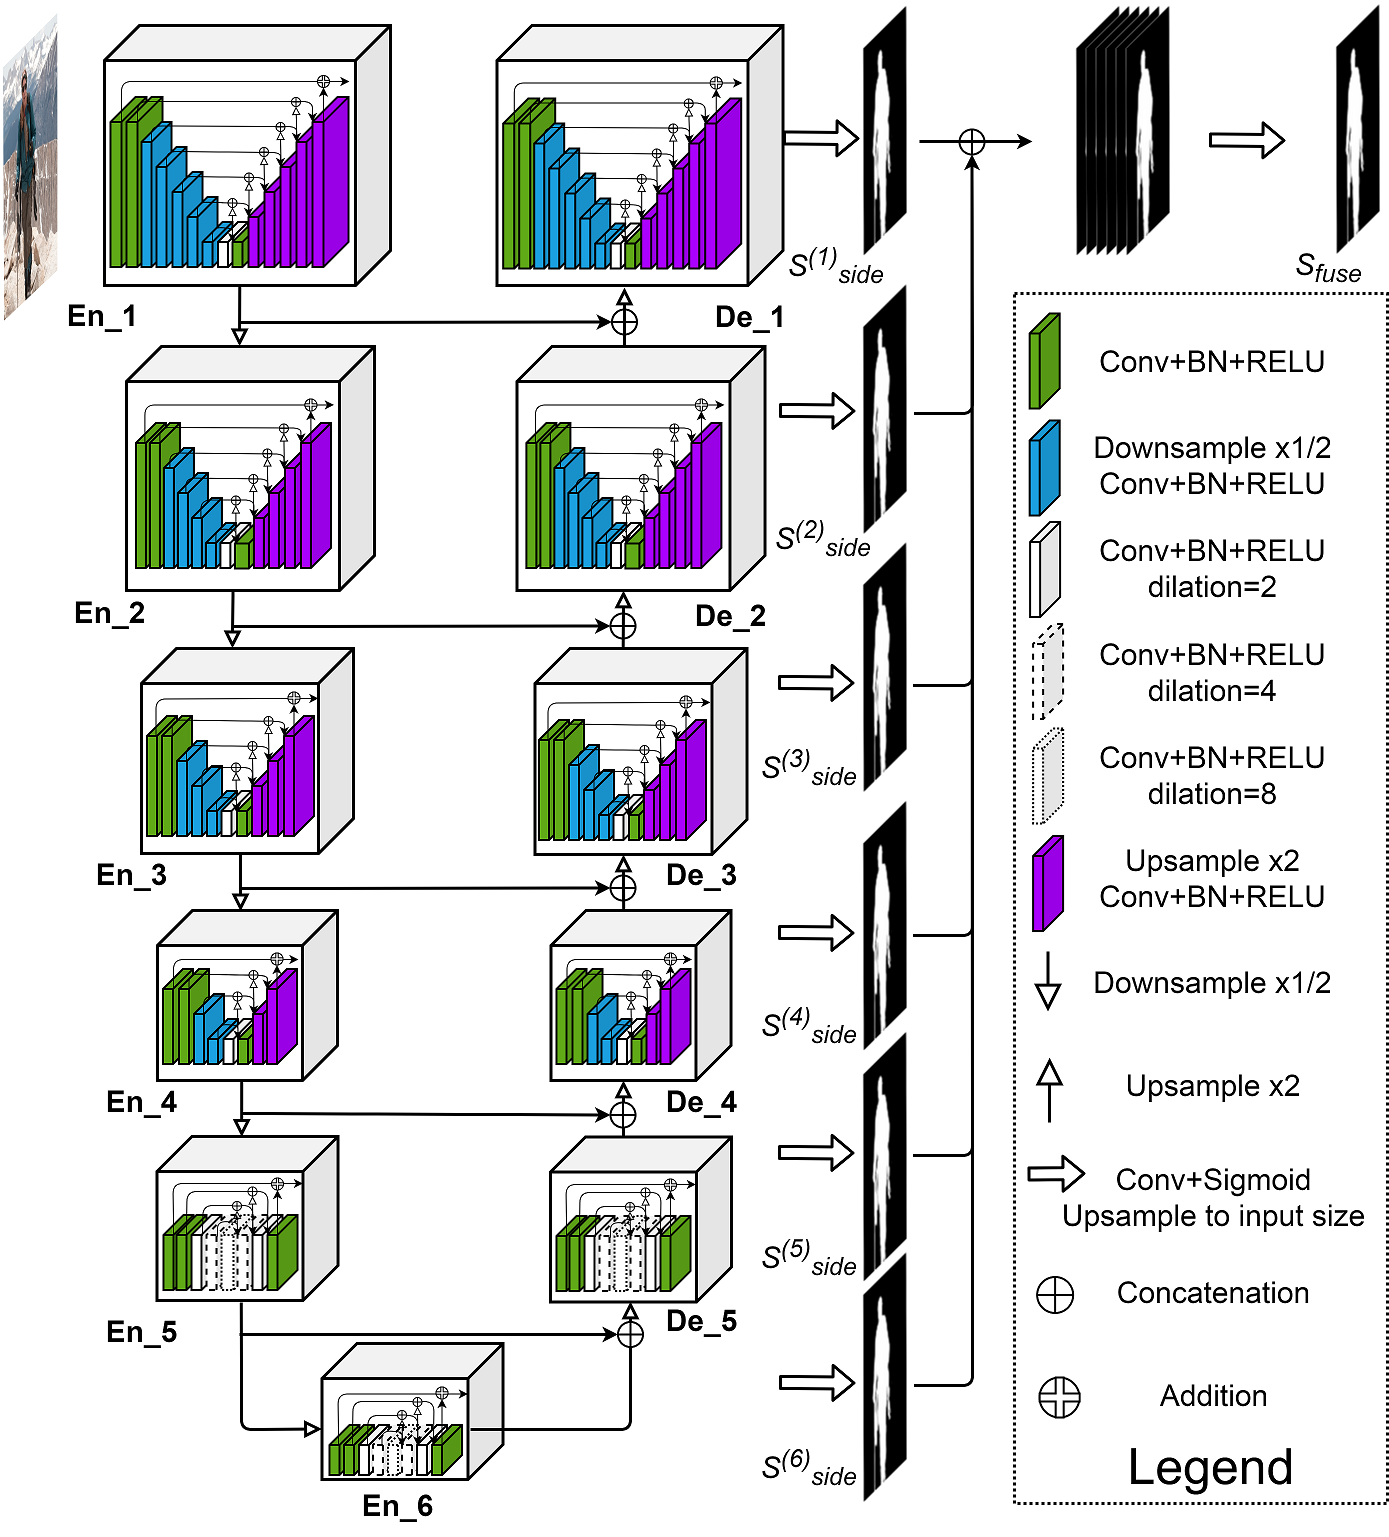

In [15]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from __future__ import print_function, division
import glob
import torch
from skimage import io, transform, color
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import os
import torchvision
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as standard_transforms

In [4]:
#Define class REBCONV
class REBNCONV(nn.Module):
    def __init__(self,in_ch=3,out_ch=3,dirate=1):
        super(REBNCONV,self).__init__()

        self.conv_s1 = nn.Conv2d(in_ch,out_ch,3,padding=1*dirate,dilation=1*dirate)
        self.bn_s1 = nn.BatchNorm2d(out_ch)
        self.relu_s1 = nn.ReLU(inplace=True)

    def forward(self,x):

        hx = x
        xout = self.relu_s1(self.bn_s1(self.conv_s1(hx)))

        return xout

In [5]:
#Define upsample function
def _upsample_like(src,tar):

    src = F.upsample(src,size=tar.shape[2:],mode='bilinear')

    return src

In [6]:
### RSU-7 ###
class RSU7(nn.Module):
    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU7,self).__init__()
        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)
        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool5 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.rebnconv7 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv6d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)
    def forward(self,x):
        hx = x
        hxin = self.rebnconvin(hx)
        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)
        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)
        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)
        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)
        hx5 = self.rebnconv5(hx)
        hx = self.pool5(hx5)
        hx6 = self.rebnconv6(hx)
        hx7 = self.rebnconv7(hx6)
        hx6d =  self.rebnconv6d(torch.cat((hx7,hx6),1))
        hx6dup = _upsample_like(hx6d,hx5)
        hx5d =  self.rebnconv5d(torch.cat((hx6dup,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)
        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)
        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)
        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)
        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))
        return hx1d + hxin

In [7]:
### RSU-6 ###
class RSU6(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU6,self).__init__()
        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)
        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool4 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.rebnconv6 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv5d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x
        hxin = self.rebnconvin(hx)
        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)
        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)
        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)
        hx4 = self.rebnconv4(hx)
        hx = self.pool4(hx4)
        hx5 = self.rebnconv5(hx)
        hx6 = self.rebnconv6(hx5)
        hx5d =  self.rebnconv5d(torch.cat((hx6,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)
        hx4d = self.rebnconv4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)
        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)
        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)
        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))
        return hx1d + hxin

In [8]:
### RSU-5 ###
class RSU5(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU5,self).__init__()
        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)
        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool3 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.rebnconv5 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv4d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)
    def forward(self,x):
        hx = x
        hxin = self.rebnconvin(hx)
        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)
        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)
        hx3 = self.rebnconv3(hx)
        hx = self.pool3(hx3)
        hx4 = self.rebnconv4(hx)
        hx5 = self.rebnconv5(hx4)
        hx4d = self.rebnconv4d(torch.cat((hx5,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)
        hx3d = self.rebnconv3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)
        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)
        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))
        return hx1d + hxin

In [9]:
### RSU-4 ###
class RSU4(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4,self).__init__()
        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)
        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.pool1 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.pool2 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=1)
        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=1)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):
        hx = x
        hxin = self.rebnconvin(hx)
        hx1 = self.rebnconv1(hxin)
        hx = self.pool1(hx1)
        hx2 = self.rebnconv2(hx)
        hx = self.pool2(hx2)
        hx3 = self.rebnconv3(hx)
        hx4 = self.rebnconv4(hx3)
        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)
        hx2d = self.rebnconv2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)
        hx1d = self.rebnconv1d(torch.cat((hx2dup,hx1),1))
        return hx1d + hxin

In [11]:
### RSU-4F ###
class RSU4F(nn.Module):

    def __init__(self, in_ch=3, mid_ch=12, out_ch=3):
        super(RSU4F,self).__init__()

        self.rebnconvin = REBNCONV(in_ch,out_ch,dirate=1)
        self.rebnconv1 = REBNCONV(out_ch,mid_ch,dirate=1)
        self.rebnconv2 = REBNCONV(mid_ch,mid_ch,dirate=2)
        self.rebnconv3 = REBNCONV(mid_ch,mid_ch,dirate=4)
        self.rebnconv4 = REBNCONV(mid_ch,mid_ch,dirate=8)
        self.rebnconv3d = REBNCONV(mid_ch*2,mid_ch,dirate=4)
        self.rebnconv2d = REBNCONV(mid_ch*2,mid_ch,dirate=2)
        self.rebnconv1d = REBNCONV(mid_ch*2,out_ch,dirate=1)

    def forward(self,x):

        hx = x
        hxin = self.rebnconvin(hx)
        hx1 = self.rebnconv1(hxin)
        hx2 = self.rebnconv2(hx1)
        hx3 = self.rebnconv3(hx2)
        hx4 = self.rebnconv4(hx3)
        hx3d = self.rebnconv3d(torch.cat((hx4,hx3),1))
        hx2d = self.rebnconv2d(torch.cat((hx3d,hx2),1))
        hx1d = self.rebnconv1d(torch.cat((hx2d,hx1),1))
        return hx1d + hxin

In [12]:
##### U^2-Net ####
class U2NET(nn.Module):

    def __init__(self,in_ch=3,out_ch=1):
        super(U2NET,self).__init__()
        self.stage1 = RSU7(in_ch,32,64)
        self.pool12 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.stage2 = RSU6(64,32,128)
        self.pool23 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.stage3 = RSU5(128,64,256)
        self.pool34 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.stage4 = RSU4(256,128,512)
        self.pool45 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.stage5 = RSU4F(512,256,512)
        self.pool56 = nn.MaxPool2d(2,stride=2,ceil_mode=True)
        self.stage6 = RSU4F(512,256,512)
        # decoder
        self.stage5d = RSU4F(1024,256,512)
        self.stage4d = RSU4(1024,128,256)
        self.stage3d = RSU5(512,64,128)
        self.stage2d = RSU6(256,32,64)
        self.stage1d = RSU7(128,16,64)
        self.side1 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side2 = nn.Conv2d(64,out_ch,3,padding=1)
        self.side3 = nn.Conv2d(128,out_ch,3,padding=1)
        self.side4 = nn.Conv2d(256,out_ch,3,padding=1)
        self.side5 = nn.Conv2d(512,out_ch,3,padding=1)
        self.side6 = nn.Conv2d(512,out_ch,3,padding=1)

        self.outconv = nn.Conv2d(6*out_ch,out_ch,1)

    def forward(self,x):

        hx = x
        hx1 = self.stage1(hx)
        hx = self.pool12(hx1)
        hx2 = self.stage2(hx)
        hx = self.pool23(hx2)
        hx3 = self.stage3(hx)
        hx = self.pool34(hx3)
        hx4 = self.stage4(hx)
        hx = self.pool45(hx4)
        hx5 = self.stage5(hx)
        hx = self.pool56(hx5)
        hx6 = self.stage6(hx)
        hx6up = _upsample_like(hx6,hx5)
        hx5d = self.stage5d(torch.cat((hx6up,hx5),1))
        hx5dup = _upsample_like(hx5d,hx4)
        hx4d = self.stage4d(torch.cat((hx5dup,hx4),1))
        hx4dup = _upsample_like(hx4d,hx3)
        hx3d = self.stage3d(torch.cat((hx4dup,hx3),1))
        hx3dup = _upsample_like(hx3d,hx2)
        hx2d = self.stage2d(torch.cat((hx3dup,hx2),1))
        hx2dup = _upsample_like(hx2d,hx1)
        hx1d = self.stage1d(torch.cat((hx2dup,hx1),1))
        d1 = self.side1(hx1d)
        d2 = self.side2(hx2d)
        d2 = _upsample_like(d2,d1)
        d3 = self.side3(hx3d)
        d3 = _upsample_like(d3,d1)
        d4 = self.side4(hx4d)
        d4 = _upsample_like(d4,d1)
        d5 = self.side5(hx5d)
        d5 = _upsample_like(d5,d1)
        d6 = self.side6(hx6)
        d6 = _upsample_like(d6,d1)
        d0 = self.outconv(torch.cat((d1,d2,d3,d4,d5,d6),1))
        return F.sigmoid(d0), F.sigmoid(d1), F.sigmoid(d2), F.sigmoid(d3), F.sigmoid(d4), F.sigmoid(d5), F.sigmoid(d6)

In [ ]:
# Define Loss function
bce_loss = nn.BCELoss(size_average=True)

def muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, labels_v):

	loss0 = bce_loss(d0,labels_v)
	loss1 = bce_loss(d1,labels_v)
	loss2 = bce_loss(d2,labels_v)
	loss3 = bce_loss(d3,labels_v)
	loss4 = bce_loss(d4,labels_v)
	loss5 = bce_loss(d5,labels_v)
	loss6 = bce_loss(d6,labels_v)

	loss = loss0 + loss1 + loss2 + loss3 + loss4 + loss5 + loss6
	print("l0: %3f, l1: %3f, l2: %3f, l3: %3f, l4: %3f, l5: %3f, l6: %3f\n"%(loss0.data.item(),loss1.data.item(),loss2.data.item(),loss3.data.item(),loss4.data.item(),loss5.data.item(),loss6.data.item()))

	return loss0, loss

In [16]:
# Define transformations data loader
class RescaleT(object):

	def __init__(self,output_size):
		assert isinstance(output_size,(int,tuple))
		self.output_size = output_size

	def __call__(self,sample):
		imidx, image, label = sample['imidx'], sample['image'],sample['label']

		h, w = image.shape[:2]

		if isinstance(self.output_size,int):
			if h > w:
				new_h, new_w = self.output_size*h/w,self.output_size
			else:
				new_h, new_w = self.output_size,self.output_size*w/h
		else:
			new_h, new_w = self.output_size

		new_h, new_w = int(new_h), int(new_w)
		img = transform.resize(image,(self.output_size,self.output_size),mode='constant')
		lbl = transform.resize(label,(self.output_size,self.output_size),mode='constant', order=0, preserve_range=True)

		return {'imidx':imidx, 'image':img,'label':lbl}

class RandomCrop(object):

	def __init__(self,output_size):
		assert isinstance(output_size, (int, tuple))
		if isinstance(output_size, int):
			self.output_size = (output_size, output_size)
		else:
			assert len(output_size) == 2
			self.output_size = output_size
	def __call__(self,sample):
		imidx, image, label = sample['imidx'], sample['image'], sample['label']

		if random.random() >= 0.5:
			image = image[::-1]
			label = label[::-1]

		h, w = image.shape[:2]
		new_h, new_w = self.output_size

		top = np.random.randint(0, h - new_h)
		left = np.random.randint(0, w - new_w)

		image = image[top: top + new_h, left: left + new_w]
		label = label[top: top + new_h, left: left + new_w]

		return {'imidx':imidx,'image':image, 'label':label}

class ToTensorLab(object):
	"""Convert ndarrays in sample to Tensors."""
	def __init__(self,flag=0):
		self.flag = flag

	def __call__(self, sample):

		imidx, image, label =sample['imidx'], sample['image'], sample['label']

		tmpLbl = np.zeros(label.shape)

		if(np.max(label)<1e-6):
			label = label
		else:
			label = label/np.max(label)

		if self.flag == 2:
			tmpImg = np.zeros((image.shape[0],image.shape[1],6))
			tmpImgt = np.zeros((image.shape[0],image.shape[1],3))
			if image.shape[2]==1:
				tmpImgt[:,:,0] = image[:,:,0]
				tmpImgt[:,:,1] = image[:,:,0]
				tmpImgt[:,:,2] = image[:,:,0]
			else:
				tmpImgt = image
			tmpImgtl = color.rgb2lab(tmpImgt)

			tmpImg[:,:,0] = (tmpImgt[:,:,0]-np.min(tmpImgt[:,:,0]))/(np.max(tmpImgt[:,:,0])-np.min(tmpImgt[:,:,0]))
			tmpImg[:,:,1] = (tmpImgt[:,:,1]-np.min(tmpImgt[:,:,1]))/(np.max(tmpImgt[:,:,1])-np.min(tmpImgt[:,:,1]))
			tmpImg[:,:,2] = (tmpImgt[:,:,2]-np.min(tmpImgt[:,:,2]))/(np.max(tmpImgt[:,:,2])-np.min(tmpImgt[:,:,2]))
			tmpImg[:,:,3] = (tmpImgtl[:,:,0]-np.min(tmpImgtl[:,:,0]))/(np.max(tmpImgtl[:,:,0])-np.min(tmpImgtl[:,:,0]))
			tmpImg[:,:,4] = (tmpImgtl[:,:,1]-np.min(tmpImgtl[:,:,1]))/(np.max(tmpImgtl[:,:,1])-np.min(tmpImgtl[:,:,1]))
			tmpImg[:,:,5] = (tmpImgtl[:,:,2]-np.min(tmpImgtl[:,:,2]))/(np.max(tmpImgtl[:,:,2])-np.min(tmpImgtl[:,:,2]))


			tmpImg[:,:,0] = (tmpImg[:,:,0]-np.mean(tmpImg[:,:,0]))/np.std(tmpImg[:,:,0])
			tmpImg[:,:,1] = (tmpImg[:,:,1]-np.mean(tmpImg[:,:,1]))/np.std(tmpImg[:,:,1])
			tmpImg[:,:,2] = (tmpImg[:,:,2]-np.mean(tmpImg[:,:,2]))/np.std(tmpImg[:,:,2])
			tmpImg[:,:,3] = (tmpImg[:,:,3]-np.mean(tmpImg[:,:,3]))/np.std(tmpImg[:,:,3])
			tmpImg[:,:,4] = (tmpImg[:,:,4]-np.mean(tmpImg[:,:,4]))/np.std(tmpImg[:,:,4])
			tmpImg[:,:,5] = (tmpImg[:,:,5]-np.mean(tmpImg[:,:,5]))/np.std(tmpImg[:,:,5])

		elif self.flag == 1:
			tmpImg = np.zeros((image.shape[0],image.shape[1],3))

			if image.shape[2]==1:
				tmpImg[:,:,0] = image[:,:,0]
				tmpImg[:,:,1] = image[:,:,0]
				tmpImg[:,:,2] = image[:,:,0]
			else:
				tmpImg = image

			tmpImg = color.rgb2lab(tmpImg)

			tmpImg[:,:,0] = (tmpImg[:,:,0]-np.min(tmpImg[:,:,0]))/(np.max(tmpImg[:,:,0])-np.min(tmpImg[:,:,0]))
			tmpImg[:,:,1] = (tmpImg[:,:,1]-np.min(tmpImg[:,:,1]))/(np.max(tmpImg[:,:,1])-np.min(tmpImg[:,:,1]))
			tmpImg[:,:,2] = (tmpImg[:,:,2]-np.min(tmpImg[:,:,2]))/(np.max(tmpImg[:,:,2])-np.min(tmpImg[:,:,2]))

			tmpImg[:,:,0] = (tmpImg[:,:,0]-np.mean(tmpImg[:,:,0]))/np.std(tmpImg[:,:,0])
			tmpImg[:,:,1] = (tmpImg[:,:,1]-np.mean(tmpImg[:,:,1]))/np.std(tmpImg[:,:,1])
			tmpImg[:,:,2] = (tmpImg[:,:,2]-np.mean(tmpImg[:,:,2]))/np.std(tmpImg[:,:,2])

		else: 
			tmpImg = np.zeros((image.shape[0],image.shape[1],3))
			image = image/np.max(image)
			if image.shape[2]==1:
				tmpImg[:,:,0] = (image[:,:,0]-0.485)/0.229
				tmpImg[:,:,1] = (image[:,:,0]-0.485)/0.229
				tmpImg[:,:,2] = (image[:,:,0]-0.485)/0.229
			else:
				tmpImg[:,:,0] = (image[:,:,0]-0.485)/0.229
				tmpImg[:,:,1] = (image[:,:,1]-0.456)/0.224
				tmpImg[:,:,2] = (image[:,:,2]-0.406)/0.225

		tmpLbl[:,:,0] = label[:,:,0]

		tmpImg = tmpImg.transpose((2, 0, 1))
		tmpLbl = label.transpose((2, 0, 1))

		return {'imidx':torch.from_numpy(imidx), 'image': torch.from_numpy(tmpImg), 'label': torch.from_numpy(tmpLbl)}

class SalObjDataset(Dataset):
	def __init__(self,img_name_list,lbl_name_list,transform=None):
		self.image_name_list = img_name_list
		self.label_name_list = lbl_name_list
		self.transform = transform

	def __len__(self):
		return len(self.image_name_list)

	def __getitem__(self,idx):

		image = io.imread(self.image_name_list[idx])
		imname = self.image_name_list[idx]
		imidx = np.array([idx])

		if(0==len(self.label_name_list)):
			label_3 = np.zeros(image.shape)
		else:
			label_3 = io.imread(self.label_name_list[idx])

		label = np.zeros(label_3.shape[0:2])
		if(3==len(label_3.shape)):
			label = label_3[:,:,0]
		elif(2==len(label_3.shape)):
			label = label_3

		if(3==len(image.shape) and 2==len(label.shape)):
			label = label[:,:,np.newaxis]
		elif(2==len(image.shape) and 2==len(label.shape)):
			image = image[:,:,np.newaxis]
			label = label[:,:,np.newaxis]

		sample = {'imidx':imidx, 'image':image, 'label':label}

		if self.transform:
			sample = self.transform(sample)

		return sample

In [17]:
# Define training dataset details

model_name = 'u2net' 

data_dir = os.path.join('data' + os.sep)
tra_image_dir = os.path.join('DUTS-TR', 'DUTS-TR-Image' + os.sep)
tra_label_dir = os.path.join('DUTS-TR', 'DUTS-TR-Mask' + os.sep)

image_ext = '.jpg'
label_ext = '.png'

model_dir = os.path.join(os.getcwd(), 'saved_models', model_name + os.sep)

epoch_num = 100000
batch_size_train = 12
batch_size_val = 1
train_num = 0
val_num = 0

tra_img_name_list = glob.glob(data_dir + tra_image_dir + '*' + image_ext)

tra_lbl_name_list = []
for img_path in tra_img_name_list:
	img_name = img_path.split(os.sep)[-1]

	aaa = img_name.split(".")
	bbb = aaa[0:-1]
	imidx = bbb[0]
	for i in range(1,len(bbb)):
		imidx = imidx + "." + bbb[i]

	tra_lbl_name_list.append(data_dir + tra_label_dir + imidx + label_ext)

print("---")
print("train images: ", len(tra_img_name_list))
print("train labels: ", len(tra_lbl_name_list))
print("---")

train_num = len(tra_img_name_list)

salobj_dataset = SalObjDataset(
    img_name_list=tra_img_name_list,
    lbl_name_list=tra_lbl_name_list,
    transform=transforms.Compose([
        RescaleT(320),
        RandomCrop(288),
        ToTensorLab(flag=0)]))
salobj_dataloader = DataLoader(salobj_dataset, batch_size=batch_size_train, shuffle=True, num_workers=1)

---
train images:  10553
train labels:  10553
---


In [ ]:
# Define model
net = U2NET(3, 1)
if torch.cuda.is_available():
    net.cuda()

In [ ]:
# Define Optimizer and Training Process
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

print("---start training...")
ite_num = 0
running_loss = 0.0
running_tar_loss = 0.0
ite_num4val = 0
save_frq = 2000 # save the model every 2000 iterations

for epoch in range(0, epoch_num):
    net.train()

    for i, data in enumerate(salobj_dataloader):
        ite_num = ite_num + 1
        ite_num4val = ite_num4val + 1

        inputs, labels = data['image'], data['label']

        inputs = inputs.type(torch.FloatTensor)
        labels = labels.type(torch.FloatTensor)

        # wrap them in Variable
        if torch.cuda.is_available():
            inputs_v, labels_v = Variable(inputs.cuda(), requires_grad=False), Variable(labels.cuda(),
                                                                                        requires_grad=False)
        else:
            inputs_v, labels_v = Variable(inputs, requires_grad=False), Variable(labels, requires_grad=False)

        # y zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        d0, d1, d2, d3, d4, d5, d6 = net(inputs_v)
        loss2, loss = muti_bce_loss_fusion(d0, d1, d2, d3, d4, d5, d6, labels_v)

        loss.backward()
        optimizer.step()

        # # print statistics
        running_loss += loss.data.item()
        running_tar_loss += loss2.data.item()

        # del temporary outputs and loss
        del d0, d1, d2, d3, d4, d5, d6, loss2, loss

        print("[epoch: %3d/%3d, batch: %5d/%5d, ite: %d] train loss: %3f, tar: %3f " % (
        epoch + 1, epoch_num, (i + 1) * batch_size_train, train_num, ite_num, running_loss / ite_num4val, running_tar_loss / ite_num4val))

        if ite_num % save_frq == 0:

            torch.save(net.state_dict(), model_dir + model_name+"_bce_itr_%d_train_%3f_tar_%3f.pth" % (ite_num, running_loss / ite_num4val, running_tar_loss / ite_num4val))
            running_loss = 0.0
            running_tar_loss = 0.0
            net.train()  # resume train
            ite_num4val = 0

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


---
train images:  10553
train labels:  10553
---
---define optimizer...
---start training...


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details

l0: 0.836829, l1: 0.700283, l2: 0.761399, l3: 0.720358, l4: 0.853971, l5: 0.689841, l6: 0.711180

[epoch:   1/100000, batch:    12/10553, ite: 1] train loss: 5.273861, tar: 0.836829 
l0: 1.430998, l1: 0.723245, l2: 0.746915, l3: 1.278243, l4: 0.664443, l5: 6.936967, l6: 0.891406

[epoch:   1/100000, batch:    24/10553, ite: 2] train loss: 8.973039, tar: 1.133913 
l0: 0.872696, l1: 0.656777, l2: 0.650895, l3: 0.783259, l4: 0.623568, l5: 2.777389, l6: 1.117794

[epoch:   1/100000, batch:    36/10553, ite: 3] train loss: 8.476152, tar: 1.046841 
l0: 0.575677, l1: 0.615073, l2: 0.589831, l3: 0.660121, l4: 0.644997, l5: 3.112661, l6: 0.590922

[epoch:   1/100000, batch:    48/10553, ite: 4] train loss: 8.054435, tar: 0.929050 
l0: 0.578834, l1: 0.534861, l2: 0.451555, l3: 0.566247, l4: 0.547711, l5: 1.384625, l6: 0.668210

[epoch:   1/100000, batch:    60/10553, ite: 5] train loss: 7.389956, tar: 0.859007 
l0: 0.578489, l1: 0.629836, l2: 0.598598, l3: 0.688167, l4: 0.811051, l5: 0.815337, l

KeyboardInterrupt: ignored

In [18]:
# Load Saved Weights and Testing Code
%cd /content
!/usr/local/cuda/bin/nvcc --version
!git clone https://github.com/shreyas-bk/U-2-Net
%cd /content/U-2-Net
print('making images directory')
!mkdir images
print('making results directory')
!mkdir results
print('importing...')
from google.colab import files
import os
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
from PIL import Image as Img
import cv2
from google.colab.patches import cv2_imshow
print('Done!')

/content
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0
Cloning into 'U-2-Net'...
remote: Enumerating objects: 520, done.
remote: Total 520 (delta 0), reused 0 (delta 0), pack-reused 520
Receiving objects: 100% (520/520), 12.39 MiB | 19.40 MiB/s, done.
Resolving deltas: 100% (234/234), done.
/content/U-2-Net
making images directory
making results directory
importing...
Done!


In [19]:
%cd /content/U-2-Net/images
uploaded = files.upload()
%cd /content/U-2-Net

/content/U-2-Net/images


Saving U_2_NETP_IMAGE1.jpg to U_2_NETP_IMAGE1.jpg
Saving U_2_NETP_IMAGE2.jpg to U_2_NETP_IMAGE2.jpg
Saving U_2_NETP_IMAGE3.jpg to U_2_NETP_IMAGE3.jpg
/content/U-2-Net


['/content/U-2-Net/images/U_2_NETP_IMAGE1.jpg', '/content/U-2-Net/images/U_2_NETP_IMAGE2.jpg', '/content/U-2-Net/images/U_2_NETP_IMAGE3.jpg']
inferencing: U_2_NETP_IMAGE1.jpg
inferencing: U_2_NETP_IMAGE2.jpg
inferencing: U_2_NETP_IMAGE3.jpg

INPUT                                    BACKGROUND REMOVED                     BOUNDING BOX                               SALIENT MAP



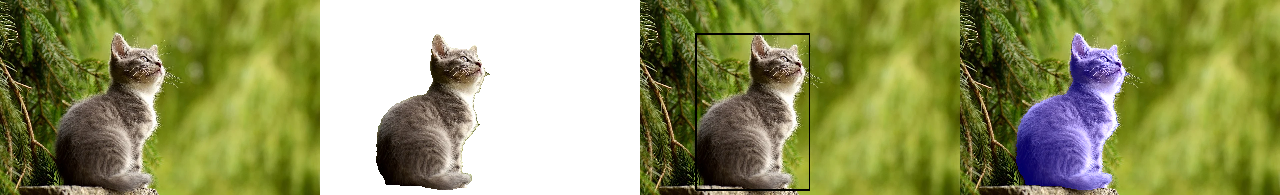


INPUT                                    BACKGROUND REMOVED                     BOUNDING BOX                               SALIENT MAP



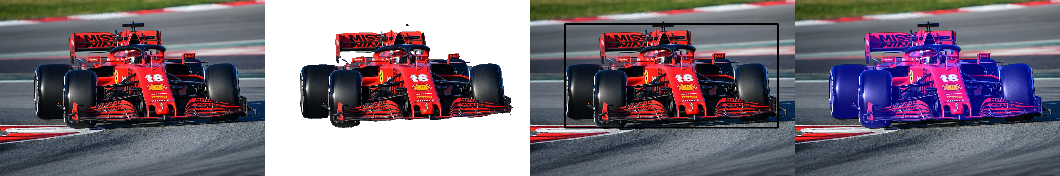


INPUT                                    BACKGROUND REMOVED                     BOUNDING BOX                               SALIENT MAP



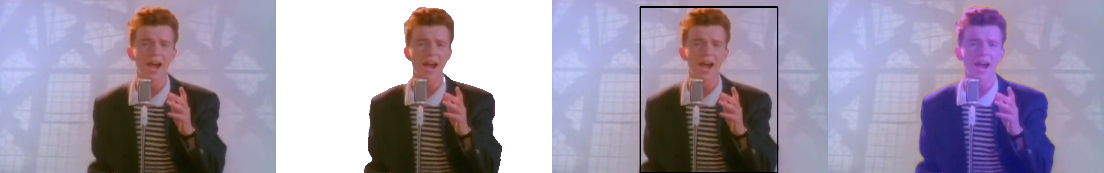

In [20]:
!python -W ignore u2net_test.py

image_dir = os.path.join(os.getcwd(), 'images')
names = [name[:-4] for name in os.listdir(image_dir)]
THRESHOLD = 0.9
RESCALE = 255
LAYER = 2
COLOR = (0, 0, 0)
THICKNESS = 4
SAL_SHIFT = 100


for name in names:

  # BACKGROUND REMOVAL

  if name == '.ipynb_checkpo':
    continue
  output = load_img('/content/U-2-Net/results/'+name+'.png')
  out_img = img_to_array(output)
  out_img /= RESCALE

  out_img[out_img > THRESHOLD] = 1
  out_img[out_img <= THRESHOLD] = 0

  shape = out_img.shape
  a_layer_init = np.ones(shape = (shape[0],shape[1],1))
  mul_layer = np.expand_dims(out_img[:,:,0],axis=2)
  a_layer = mul_layer*a_layer_init
  rgba_out = np.append(out_img,a_layer,axis=2)

  input = load_img('/content/U-2-Net/images/'+name+'.jpg')
  inp_img = img_to_array(input)
  inp_img /= RESCALE

  a_layer = np.ones(shape = (shape[0],shape[1],1))
  rgba_inp = np.append(inp_img,a_layer,axis=2)

  rem_back = (rgba_inp*rgba_out)
  rem_back_scaled = rem_back*RESCALE

  # BOUNDING BOX CREATION

  out_layer = out_img[:,:,LAYER]
  x_starts = [np.where(out_layer[i]==1)[0][0] if len(np.where(out_layer[i]==1)[0])!=0 else out_layer.shape[0]+1 for i in range(out_layer.shape[0])]
  x_ends = [np.where(out_layer[i]==1)[0][-1] if len(np.where(out_layer[i]==1)[0])!=0 else 0 for i in range(out_layer.shape[0])]
  y_starts = [np.where(out_layer.T[i]==1)[0][0] if len(np.where(out_layer.T[i]==1)[0])!=0 else out_layer.T.shape[0]+1 for i in range(out_layer.T.shape[0])]
  y_ends = [np.where(out_layer.T[i]==1)[0][-1] if len(np.where(out_layer.T[i]==1)[0])!=0 else 0 for i in range(out_layer.T.shape[0])]
  
  startx = min(x_starts)
  endx = max(x_ends)
  starty = min(y_starts)
  endy = max(y_ends)
  start = (startx,starty)
  end = (endx,endy)

  box_img = inp_img.copy()
  box_img = cv2.rectangle(box_img, start, end, COLOR, THICKNESS)
  box_img = np.append(box_img,a_layer,axis=2)
  box_img_scaled = box_img*RESCALE

  # SALIENT FEATURE MAP

  sal_img = inp_img.copy()
  add_layer = out_img.copy()
  add_layer[add_layer==1] = SAL_SHIFT/RESCALE
  sal_img[:,:,LAYER] += add_layer[:,:,LAYER]
  sal_img = np.append(sal_img,a_layer,axis=2)
  sal_img_scaled = sal_img*RESCALE
  sal_img_scaled[sal_img_scaled>RESCALE] = RESCALE

  # OUTPUT RESULTS

  inp_img*=RESCALE
  inp_img = np.append(inp_img,RESCALE*a_layer,axis=2)
  inp_img = cv2.resize(inp_img,(int(shape[1]/3),int(shape[0]/3)))
  rem_back = cv2.resize(rem_back_scaled,(int(shape[1]/3),int(shape[0]/3)))
  box_img = cv2.resize(box_img_scaled,(int(shape[1]/3),int(shape[0]/3)))
  sal_img = cv2.resize(sal_img_scaled,(int(shape[1]/3),int(shape[0]/3)))
  result = np.concatenate((inp_img,rem_back,box_img,sal_img),axis=1)
  result_img = Img.fromarray(result.astype('uint8'), 'RGBA')
  print('\nINPUT                                    BACKGROUND REMOVED                     BOUNDING BOX                               SALIENT MAP\n')
  display(result_img)